<a href="https://colab.research.google.com/github/msadiq058/Lung-Cancer-Detection/blob/master/Using_transfer_learning_using_1500_images_inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing necessary libraries**

In [1]:
import os, shutil
from shutil import copyfile
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3

**Adding the kaggle json file for downloading the dataset from kaggle**

In [2]:
import os
from google.colab import files
if ('kaggle.json' not in os.listdir('/content')):
  files.upload()
  
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Downloading the dataset**


In [3]:
!kaggle datasets download --force -d andrewmvd/lung-and-colon-cancer-histopathological-images 

100% 1.76G/1.76G [00:22<00:00, 85.2MB/s]
100% 1.76G/1.76G [00:22<00:00, 82.3MB/s]


**Unzipping the dataset.** 

In [4]:
!unzip -q lung-and-colon-cancer-histopathological-images.zip

**Making directories for image processing**

In [5]:
def make_dir():
  src = '/content/lung_model'
  os.mkdir(src)
  os.mkdir(os.path.join(src,'train'))
  os.mkdir(os.path.join(src,'val'))
  os.mkdir(os.path.join(src,'train/lung_aca'))
  os.mkdir(os.path.join(src,'train/lung_n'))
  os.mkdir(os.path.join(src,'train/lung_scc'))
  os.mkdir(os.path.join(src,'val/lung_aca'))
  os.mkdir(os.path.join(src,'val/lung_n'))
  os.mkdir(os.path.join(src,'val/lung_scc'))
make_dir()

**Function to split the dataset**

In [6]:
def split_data(source,train,test,split_size):

  train_size  = 500
  test_size = 150 

  for i in os.listdir(source):
      if (train_size>0):
          im_path = source+"/"+i
          copyfile(im_path,train+"/"+i)
          train_size-=1

      elif (test_size>0):
          im_path = source+"/"+i
          copyfile(im_path,test+"/"+i)
          test_size-=1

      else: break

**Splitting the dataset**

In [7]:
def call_split_data():
  
  src_lung = '/content/lung_colon_image_set/lung_image_sets'
  train_path= '/content/lung_model/train'
  val_path = '/content/lung_model/val'

  dirct = ['lung_aca','lung_n','lung_scc']
  split_size = 0.95
  for i in dirct:

    src = os.path.join(src_lung,i)
    train = os.path.join(train_path,i)
    val = os.path.join(val_path,i)

    split_data(src,train,val,split_size)

call_split_data()

**Identifying the size of directories**

In [8]:
def print_len_dir():

  train_path= '/content/lung_model/train'
  val_path = '/content/lung_model/val'

  dirct = ['lung_aca','lung_n','lung_scc']
  for i in dirct:
    
    train = os.path.join(train_path,i)
    val = os.path.join(val_path,i)

    print(train,len(os.listdir(train)))
    print(val,len(os.listdir(val)))

print_len_dir()

/content/lung_model/train/lung_aca 500
/content/lung_model/val/lung_aca 150
/content/lung_model/train/lung_n 500
/content/lung_model/val/lung_n 150
/content/lung_model/train/lung_scc 500
/content/lung_model/val/lung_scc 150


**Designing image data generator**

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    horizontal_flip = True,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
)

val_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    horizontal_flip = True,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
)

In [10]:
target_size = (240,240)

In [11]:
train_generator = train_datagen.flow_from_directory(
    '/content/lung_model/train',
    target_size = target_size,
    shuffle = True,
    class_mode = 'categorical',
    batch_size  = 16
)

Found 1500 images belonging to 3 classes.


In [12]:
val_generator = val_datagen.flow_from_directory(
    '/content/lung_model/val',
    target_size = target_size,
    batch_size = 8,
    class_mode= 'categorical',
    shuffle = True
)

Found 450 images belonging to 3 classes.


**Designing the model**

In [13]:
base_model = InceptionV3(include_top = False,input_shape = (240,240,3), 
                    weights = 'imagenet'
                    )

87916544/87910968 [==============================] - 0s 0us/step


In [14]:
print(len(base_model.layers))

311


In [15]:
for layer in base_model.layers[:296]:
  layer.trainable = False

In [16]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 119, 119, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 119, 119, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 119, 119, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Flatten(),
      Dense(1024,activation = 'relu'),
      Dropout(0.4),
      Dense(3,activation = 'softmax')  
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 23,904,035
Trainable params: 2,496,131
Non-trainable params: 21,407,904
____________________________________

**Model Compilation**

In [18]:
from tensorflow.keras.optimizers import RMSprop

In [19]:
model.compile(optimizer = RMSprop(lr = 0.0001),loss = 'categorical_crossentropy',metrics = ['acc'])

**Fitting the model for 10 epochs**

In [21]:
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)
history = model.fit(train_generator,epochs = 10,steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,validation_steps = validation_steps )

Epoch 1/10
94/94 [==============================] - 43s 459ms/step - loss: 0.4664 - acc: 0.7993 - val_loss: 0.2201 - val_acc: 0.9067
Epoch 2/10
94/94 [==============================] - 41s 440ms/step - loss: 0.2328 - acc: 0.9067 - val_loss: 0.1620 - val_acc: 0.9422
Epoch 3/10
94/94 [==============================] - 41s 438ms/step - loss: 0.2317 - acc: 0.9060 - val_loss: 0.1842 - val_acc: 0.9244
Epoch 4/10
94/94 [==============================] - 41s 433ms/step - loss: 0.2072 - acc: 0.9140 - val_loss: 0.1605 - val_acc: 0.9378
Epoch 5/10
94/94 [==============================] - 41s 432ms/step - loss: 0.1718 - acc: 0.9360 - val_loss: 0.1733 - val_acc: 0.9289
Epoch 6/10
94/94 [==============================] - 40s 429ms/step - loss: 0.1832 - acc: 0.9247 - val_loss: 0.1522 - val_acc: 0.9356
Epoch 7/10
94/94 [==============================] - 40s 425ms/step - loss: 0.1854 - acc: 0.9220 - val_loss: 0.1444 - val_acc: 0.9422
Epoch 8/10
94/94 [==============================] - 40s 422ms/step - 

**Plotting the accuracy and loss graph**

In [22]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and validation loss')

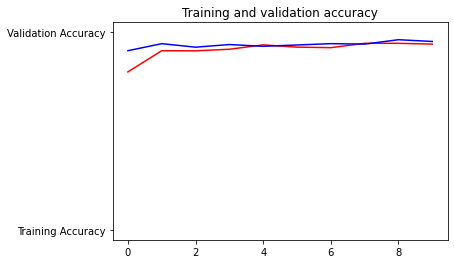

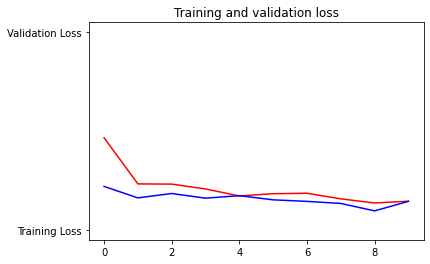

In [23]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')